In [1]:
import numpy as np
import pandas as pd
import bambi as bmb
import scipy.stats as stats
from typing import Sequence
from matplotlib import pyplot as plt
from dataclasses import dataclass, field
from numpy.typing import NDArray
from cmdstanpy import CmdStanModel, CmdStanMCMC
from data335 import lm
from arviz import InferenceData

In [2]:
model = CmdStanModel(stan_file="slr.stan")
hibbs = pd.read_csv("../data/hibbs.csv")
data = {"N": len(hibbs), "x": hibbs["growth"], "y": hibbs["vote"]}

In [3]:
fit = model.sample(data)

11:29:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:07 - cmdstanpy - INFO - CmdStan done processing.


In [4]:
draws = fit.draws_pd()[["a", "b", "sigma"]]
draws

,a,b,sigma
0,44.1052,4.29190,2.89128
1,45.1395,3.37226,3.43163
2,45.0430,4.32875,3.29978
3,47.7658,1.97412,4.21358
4,49.6866,1.25895,3.93010
...,...,...,...
3995,43.8671,3.67162,4.46861
3996,44.0549,3.56198,3.50739
3997,46.4954,2.51045,3.71510
3998,46.8533,3.41099,4.53252


In [5]:
mtcars = pd.read_csv("../data/mtcars.csv", index_col="model")
target = "mpg"
features = [c for c in mtcars.columns if c != target]

In [6]:
y = mtcars[target].to_numpy()
x = mtcars[features].to_numpy()
N, K = x.shape
data = {"N": N, "K": K, "x": x, "y": y}

In [7]:
model = CmdStanModel(stan_file="lr.stan")

In [8]:
fit = model.sample(data)

11:29:07 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:10 - cmdstanpy - INFO - CmdStan done processing.
11:29:10 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 2 had 1 iterations at max treedepth (0.1%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


In [9]:
@dataclass(kw_only=True)
class StanLMFit:
    target: str
    features: Sequence[str]
    model: CmdStanModel
    stan_mcmc: CmdStanMCMC = field(repr=False)
    draws: pd.DataFrame = field(init=False, repr=False)

    median: pd.Series = field(init=False, repr=False)
    mad_sd: pd.Series = field(init=False, repr=False)
    summary: pd.DataFrame = field(init=False)

    def __post_init__(self):
        stan_mcmc = self.stan_mcmc
        features = self.features

        stan_draws = stan_mcmc.draws_pd()
        draws = pd.DataFrame(
            {
                "(Intercept)": stan_draws["alpha"],
                **{
                    feature: stan_draws[f"beta[{i + 1}]"]
                    for i, feature in enumerate(features)
                },
                "sigma": stan_draws["sigma"],
            }
        )

        median = draws.median()
        median.name = "median"
        mad_sd = pd.Series(
            stats.median_abs_deviation(draws, axis=0), median.index, name="mad_sd"
        )
        summary = pd.concat([median, mad_sd], axis=1)

        self.draws = draws
        self.median = median
        self.mad_sd = mad_sd
        self.summary = summary

    def _repr_html_(self):
        summary = self.summary
        return summary._repr_html_()  # type: ignore


def stan_lm(
    data: pd.DataFrame,
    *,
    features: Sequence[str] | None = None,
    target: str,
):
    y = data[target].to_numpy(dtype=np.float64)
    N = len(y)
    if features is None:
        features = [c for c in data.columns if c != target]
    x = data[features].to_numpy(dtype=np.float64)
    K = x.shape[1]
    if K == 0:
        raise Exception(f"Degeneate data matrix: shape = {x.shape}")
    stan_data = dict(N=N, K=K, x=x, y=y)
    model = CmdStanModel(stan_file="lr.stan")
    stan_mcmc = model.sample(data=stan_data)
    fit = StanLMFit(
        target=target,
        features=features,
        model=model,
        stan_mcmc=stan_mcmc,
    )
    return fit

In [10]:
earnings = pd.read_csv("../data/earnings.csv")
hw = earnings[["height", "weight"]].dropna()
hw["height"] = hw["height"] - hw["height"].mean()

In [11]:
stan_fit = stan_lm(hw, target="weight", features=["height"])
stan_fit

11:29:10 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

11:29:11 - cmdstanpy - INFO - CmdStan done processing.


,median,mad_sd
(Intercept),156.29950,0.43450
height,4.94634,0.12032
sigma,28.96285,0.32460


In [12]:
model = stan_fit.model
model

CmdStanModel: name=lr
	 stan_file=/Users/mgreenbe/DATA335W2025/code/lr.stan
	 exe_file=/Users/mgreenbe/DATA335W2025/code/lr
	 compiler_options=stanc_options={}, cpp_options={}

In [13]:
lm_fit = lm(hw, target="weight", features=["height"])
lm_fit

,estimate,standard error,t-statistic,p-value
(Intercept),156.305198,0.68451,228.346169,0.0
height,4.949380,0.178467,27.732684,0.0
sigma,28.952420,,,


In [14]:
@dataclass
class BambiLMFit:
    formula: str
    model: bmb.Model
    inference_data: InferenceData = field(repr=False)
    draws: pd.DataFrame = field(init=False, repr=False)
    summary: pd.DataFrame = field(init=False)

    def __post_init__(self):
        inference_data = self.inference_data
        posterior = inference_data["posterior"]
        draws = pd.DataFrame(
            dict({k: v.to_numpy().ravel() for k, v in posterior.data_vars.items()})
        )

        median = draws.median()
        median.name = "median"
        mad_sd = pd.Series(
            stats.median_abs_deviation(draws, axis=0), median.index, name="mad_sd"
        )
        summary = pd.concat([median, mad_sd], axis=1)

        self.draws = draws
        self.median = median
        self.mad_sd = mad_sd
        self.summary = summary

    def _repr_html_(self):
        summary = self.summary
        return summary._repr_html_()  # type: ignore


def bambi_lm(
    formula: str,
    data: pd.DataFrame,
):
    model = bmb.Model(formula, data)
    inference_data = model.fit()
    bambi_lm_fit = BambiLMFit(
        formula=formula, model=model, inference_data=inference_data
    )
    return bambi_lm_fit

In [15]:
bambi_fit = bambi_lm("weight ~ height", hw)
bambi_fit

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, height]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,median,mad_sd
sigma,28.965635,0.328380
Intercept,156.292351,0.495862
height,4.951193,0.120981


Sampling: [Intercept, height, sigma]


array([<Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'height'}>], dtype=object)

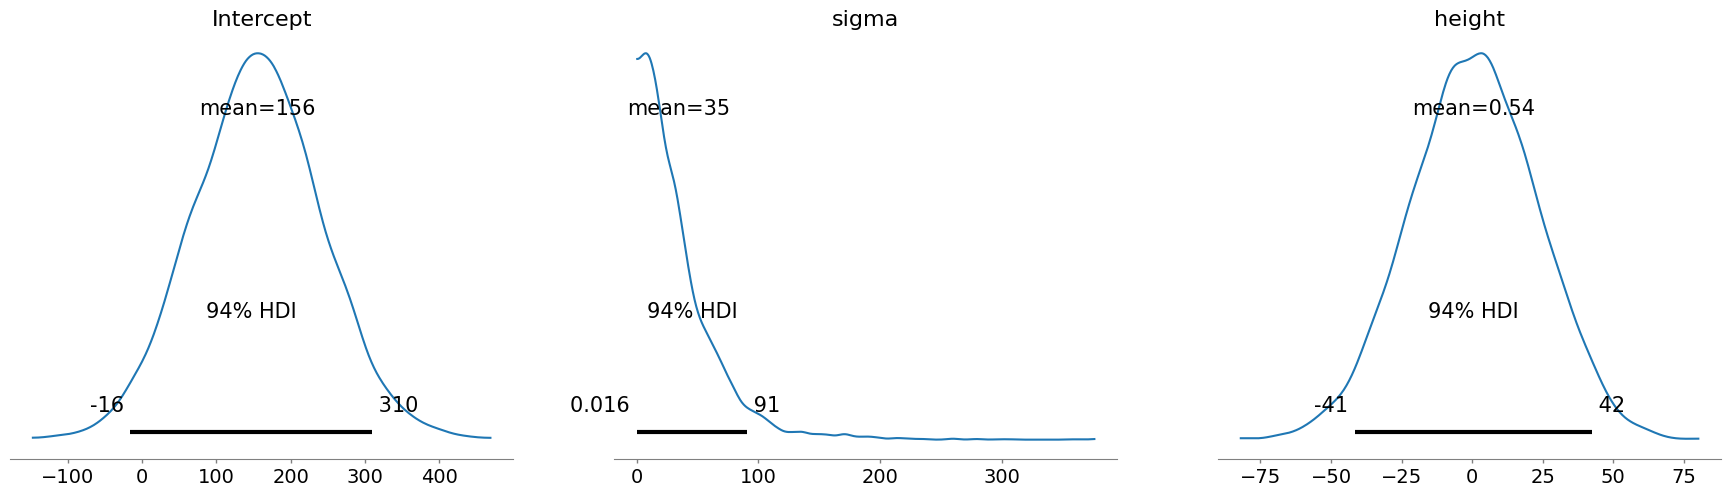

In [16]:
model = bambi_fit.model
model.plot_priors()

In [17]:
stan_fit

,median,mad_sd
(Intercept),156.29950,0.43450
height,4.94634,0.12032
sigma,28.96285,0.32460


In [18]:
import pymc as pm
import scipy.stats as stats
import bambi as bmb
import pandas as pd
import numpy as np
from data335 import mad

In [19]:
with pm.Model():
    mu = pm.Normal("mu", mu=0.524, sigma=0.041)
    x = pm.Normal("x", mu=mu, sigma=0.025, observed=[0.475])
    idata = pm.sample()

mu = idata["posterior"].data_vars["mu"].to_numpy().ravel()
print()
print(f"mu.mean() = {mu.mean():.3f}, mu.std() = {mu.std():.3f}")
print(f"np.median(mu) = {np.median(mu):.3f}, mad(mu) = {mad(mu):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



mu.mean() = 0.488, mu.std() = 0.021
np.median(mu) = 0.487, mad(mu) = 0.021


In [20]:
with pm.Model():
    mu = pm.Normal("mu", mu=0.524, sigma=0.041)
    x = pm.Normal("x", mu=mu, sigma=0.075, observed=[0.475])
    idata = pm.sample()

mu = idata["posterior"].data_vars["mu"].to_numpy().ravel()
print()
print(f"mu.mean() = {mu.mean():.3f}, mu.std() = {mu.std():.3f}")
print(f"np.median(mu) = {np.median(mu):.3f}, mad(mu) = {mad(mu):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



mu.mean() = 0.512, mu.std() = 0.037
np.median(mu) = 0.511, mad(mu) = 0.037


In [21]:
with pm.Model():
    p = pm.Normal("p", mu=0.524, sigma=0.041)  # prior
    y = pm.Binomial("y", n=400, p=p, observed=[np.round(0.475 * 400)])  # data
    posterior = pm.sample()["posterior"]  # posterior

p = posterior.data_vars["p"].to_numpy().ravel()
print()
print(f"p.mean() = {p.mean():.3f}, p.std() = {p.std():.3f}")
print(f"np.median(p) = {np.median(p):.3f}, mad(p) = {mad(p):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



p.mean() = 0.488, p.std() = 0.021
np.median(p) = 0.489, mad(p) = 0.022


In [22]:
with pm.Model():
    p = pm.Normal("p", mu=0.524, sigma=0.041)  # prior
    y = pm.Binomial("y", n=44, p=p, observed=[np.round(0.475 * 44)])  # data
    posterior = pm.sample()["posterior"]  # posterior

p = posterior.data_vars["p"].to_numpy().ravel()
print()
print(f"p.mean() = {p.mean():.3f}, p.std() = {p.std():.3f}")
print(f"np.median(p) = {np.median(p):.3f}, mad(p) = {mad(p):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



p.mean() = 0.512, p.std() = 0.036
np.median(p) = 0.512, mad(p) = 0.035


In [23]:
# Hat tip John D. Cook!
# https://www.johndcook.com/blog/2021/04/07/beta-given-mean-variance/

mu = 0.524
sigma = 0.041

a = mu * (mu * (1 - mu) / sigma**2 - 1)
b = a * (1 - mu) / mu

assert np.allclose(a / (a + b), [mu, stats.beta(a, b).mean()])
assert np.allclose(
    np.sqrt(a * b / (a + b) ** 2 / (a + b + 1)), [sigma, stats.beta(a, b).std()]
)

In [24]:
with pm.Model():
    p = pm.Beta("p", alpha=a, beta=b)  # prior
    y = pm.Binomial("y", n=400, p=p, observed=[np.round(0.475 * 400)])  # data
    posterior = pm.sample()["posterior"]  # posterior

p = posterior.data_vars["p"].to_numpy().ravel()
print()
print(f"p.mean() = {p.mean():.3f}, p.std() = {p.std():.3f}")
print(f"np.median(p) = {np.median(p):.3f}, mad(p) = {mad(p):.3f}")

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.



p.mean() = 0.488, p.std() = 0.021
np.median(p) = 0.488, mad(p) = 0.022


In [25]:
a, b

(77.22625342058299, 70.15209280190363)

In [26]:
y0 = np.round(a)
n0 = np.round(a + b)
p0 = y0 / n0
se0 = np.sqrt(p0 * (1 - p0) / n0)
y0, n0, se0

(77.0, 147.0, 0.041192521824455666)

In [27]:
y = 190
n = 400

In [28]:
p = (y + y0) / (n + n0)
se = np.sqrt(p * (1 - p) / (n + n0))
p, se

(0.48811700182815354, 0.02137241787024956)

#### Sex ratio logistic regression

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
N = 3000
n1 = 300
y1 = int(np.round(0.44 * n1))
n0 = N - n1
y0 = int(np.round(0.52 * n0))

X = np.concatenate([np.zeros(n0), np.ones(n1)])
Y0 = np.zeros(n0)
Y0[:y0] = 1
Y1 = np.zeros(n1)
Y1[:y1] = 1
Y = np.concatenate([Y0, Y1])

In [31]:
model = LogisticRegression()
model.fit(X.reshape(-1, 1), Y)
model.coef_

array([[-0.31538062]])

### Chapter 10

In [259]:
from sklearn.linear_model import LinearRegression
from matplotlib.axes import Axes
from numbers import Real
from sklearn.utils.validation import check_is_fitted
from typing import Any

In [260]:
kidiq = pd.read_csv("../data/kidiq.csv")
kidiq

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27
...,...,...,...,...,...
429,94,0,84.877412,4,21
430,76,1,92.990392,4,23
431,50,0,94.859708,2,24
432,88,1,96.856624,2,21


In [261]:
kid_score = kidiq["kid_score"]
mom_hs = kidiq[["mom_hs"]]
mom_iq = kidiq[["mom_iq"]]

mom_hs_model = LinearRegression()
mom_hs_model.fit(mom_hs, kid_score)
a_hs = mom_hs_model.intercept_
b_hs = mom_hs_model.coef_[0]

mom_iq_model = LinearRegression()
mom_iq_model.fit(mom_iq, kid_score)
a_iq = mom_iq_model.intercept_
b_iq = mom_iq_model.coef_[0]

In [264]:
def plot_regression_line(
    model,
    ax: Axes | None = None,
    xlim: tuple[Any, Any] | None = None,
    ylim: tuple[Any, Any] | None = None,
    **kwargs
):
    if isinstance(model, LinearRegression):
        check_is_fitted(estimator=model, attributes=("intercept_", "coef_"))
        a = model.intercept_
        b = model.coef_[0]
    else:
        a = model[0]
        b = model[1]
    ax = plt.gca() if ax is None else ax
    if xlim is not None:
        xmin = xlim[0]
        xmax = xlim[1]
        ax.set_xlim(xmin, xmax)
    else:
        xmin, xmax = ax.get_xlim()
    if ylim is not None:
        ymin = ylim[0]
        ymax = ylim[1]
        ax.set_ylim(ymin, ymax)
    ax.plot([xmin, xmax], [a + b * xmin, a + b * xmax], **kwargs)

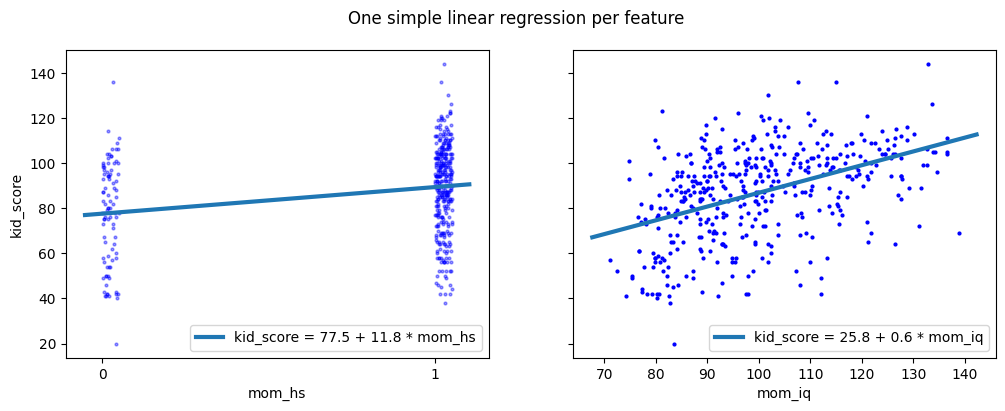

In [265]:
fig, (ax_hs, ax_iq) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 4))

fig.suptitle("One simple linear regression per feature")

jitter = 0.05 * np.random.uniform(size=mom_hs.shape)
ax_hs.scatter(mom_hs + jitter, kid_score, s=4, color=(0, 0, 1, 0.4))
ax_hs.set_xlabel("mom_hs")
ax_hs.set_xticks([0, 1])
ax_hs.set_ylabel("kid_score")
plot_regression_line(
    mom_hs_model, ax=ax_hs, lw=3, label=f"kid_score = {a_hs:.1f} + {b_hs:.1f} * mom_hs"
)
ax_hs.legend(loc="lower right")

kidiq.plot.scatter("mom_iq", "kid_score", ax=ax_iq, s=4, color=(0, 0, 1))
plot_regression_line(
    mom_iq_model, ax=ax_iq, lw=3, label=f"kid_score = {a_iq:.1f} + {b_iq:.1f} * mom_iq"
)
ax_iq.legend(loc="lower right")
plt.show()

#### Linear regression with two predictors

In [266]:
model = LinearRegression()
model.fit(kidiq[["mom_hs", "mom_iq"]], kidiq["kid_score"])
a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]
print(
    f"kid_score   =   {a:.1f}   +   {b:.1f} * mom_hs   +   {c:.1f} * mom_iq   +   error"
)

kid_score   =   25.7   +   6.0 * mom_hs   +   0.6 * mom_iq   +   error


In [293]:
lm(kidiq, features=["mom_hs", "mom_iq"], target="kid_score")

,estimate,standard error,t-statistic,p-value
(Intercept),25.731538,5.875208,4.379681,0.000015
mom_hs,5.950117,2.211812,2.690155,0.007419
mom_iq,0.563906,0.060574,9.309362,0.0
sigma,18.135676,,,


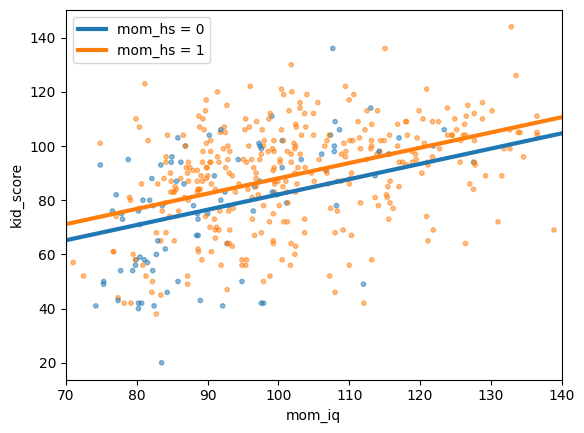

In [269]:
kidiq.plot.scatter(
    "mom_iq",
    "kid_score",
    s=10,
    c=["C0" if x == 0 else "C1" for x in kidiq["mom_hs"]],
    alpha=0.5,
)
plot_regression_line((a, c), lw=3, label="mom_hs = 0", xlim=(70, 140))
plot_regression_line((a + b, c), lw=3, label="mom_hs = 1", xlim=(70, 140))
plt.legend()
plt.show()

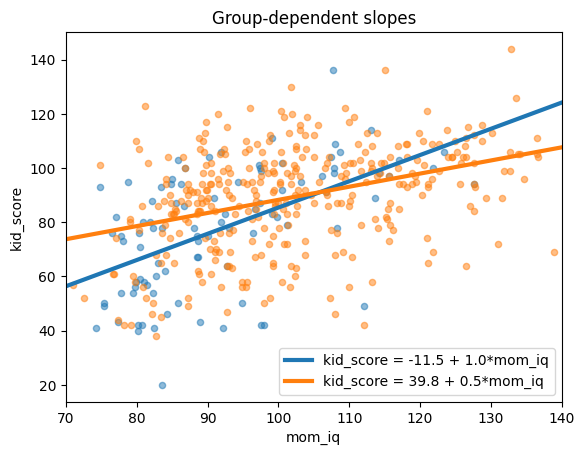

In [ ]:
ax = plt.gca()
for hs, group in kidiq.groupby("mom_hs"):
    group.plot.scatter("mom_iq", "kid_score", color=f"C{hs}", alpha=0.5, ax=ax)
    model = LinearRegression()
    model.fit(group[["mom_iq"]], group["kid_score"])
    a = model.intercept_
    b = model.coef_[0]
    plot_regression_line(
        model,
        lw=3,
        ax=ax,
        xlim=(70, 140),
        label=f"kid_score = {a:.1f} + {b:.1f}*mom_iq",
    )
ax.legend()
ax.set_title("Group-dependent slopes")
plt.show()

In [289]:
kidiq["mom_hs:mom_iq"] = kidiq["mom_hs"] * kidiq["mom_iq"]

model = LinearRegression()
model.fit(kidiq[["mom_hs", "mom_iq", "mom_hs:mom_iq"]], kidiq["kid_score"])
a = model.intercept_
b = model.coef_[0]
c = model.coef_[1]
d = model.coef_[2]
print(
    f"kid_score  =  {a:.1f}  +  {b:.1f} * mom_hs  +  {c:.1f} * mom_iq  +  {d:.1f} * mom_hs:mom_iq  +   error"
)
print("\nIf mom_hs = 0:")
print(f"kid_score  =  {a:.1f}  +  {c:.1f} * mom_iq  +  error")
print("\nIf mom_hs = 1:")
print(f"kid_score  =   {a + b:.1f}  +  {c + d:.1f} * mom_iq  +  error")

kid_score  =  -11.5  +  51.3 * mom_hs  +  1.0 * mom_iq  +  -0.5 * mom_hs:mom_iq  +   error

If mom_hs = 0:
kid_score  =  -11.5  +  1.0 * mom_iq  +  error

If mom_hs = 1:
kid_score  =   39.8  +  0.5 * mom_iq  +  error


In [290]:
lm(kidiq, features=["mom_hs", "mom_iq", "mom_hs:mom_iq"], target="kid_score")

,estimate,standard error,t-statistic,p-value
(Intercept),-11.482021,13.757974,-0.834572,0.404422
mom_hs,51.268223,15.337581,3.342654,0.000902
mom_iq,0.968889,0.148344,6.53138,0.0
mom_hs:mom_iq,-0.484275,0.162217,-2.98535,0.002994
sigma,17.971466,,,


In [292]:
stan_lm(kidiq, features=["mom_hs", "mom_iq", "mom_hs:mom_iq"], target="kid_score")

16:10:36 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

16:10:37 - cmdstanpy - INFO - CmdStan done processing.


,median,mad_sd
(Intercept),-12.187200,9.343250
mom_hs,51.672400,10.254400
mom_iq,0.975067,0.100473
mom_hs:mom_iq,-0.489913,0.107881
sigma,17.969550,0.395300


In [291]:
bambi_lm("kid_score ~ mom_hs + mom_iq + mom_hs:mom_iq", kidiq)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, mom_hs, mom_iq, mom_hs:mom_iq]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


,median,mad_sd
sigma,17.992292,0.414806
Intercept,-10.031176,9.376823
mom_hs,49.360884,10.431495
mom_iq,0.951695,0.100784
mom_hs:mom_iq,-0.463889,0.109570
